In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif


In [2]:
# Load the dataset
data = np.loadtxt('activity_new_data.txt', delimiter=',')
X = data[:, 1:]
y = data[:, 0].astype(int)


In [3]:

# 1. Define parameter grids for each model
param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [4, 5],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [0.8]
}

param_grid_gb = {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [4, 5],
    'clf__subsample': [0.8]
}

In [4]:
# 2. Define pipelines
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=42))
])

In [ ]:
# ------------------------------------------
# 3. Grid Search
print("\n=== Grid Search: XGBoost ===")
grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_xgb.fit(X, y)
print("Best parameters (XGB):", grid_xgb.best_params_)
print("Best accuracy (XGB):", grid_xgb.best_score_)

print("\n=== Grid Search: Gradient Boosting ===")
grid_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_gb.fit(X, y)
print("Best parameters (GB):", grid_gb.best_params_)
print("Best accuracy (GB):", grid_gb.best_score_)


=== Grid Search: XGBoost ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters (XGB): {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}
Best accuracy (XGB): 0.961111111111111

=== Grid Search: Gradient Boosting ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
# 4. Export results
results = pd.DataFrame([
    {"Model": "XGBoost", "Best Params": grid_xgb.best_params_, "Best Accuracy": grid_xgb.best_score_},
    {"Model": "GradientBoosting", "Best Params": grid_gb.best_params_, "Best Accuracy": grid_gb.best_score_}
])
results.to_csv("fine_tuned_results.csv", index=False)
print("\nResults saved to 'fine_tuned_results.csv'")



Results saved to 'fine_tuned_results.csv'


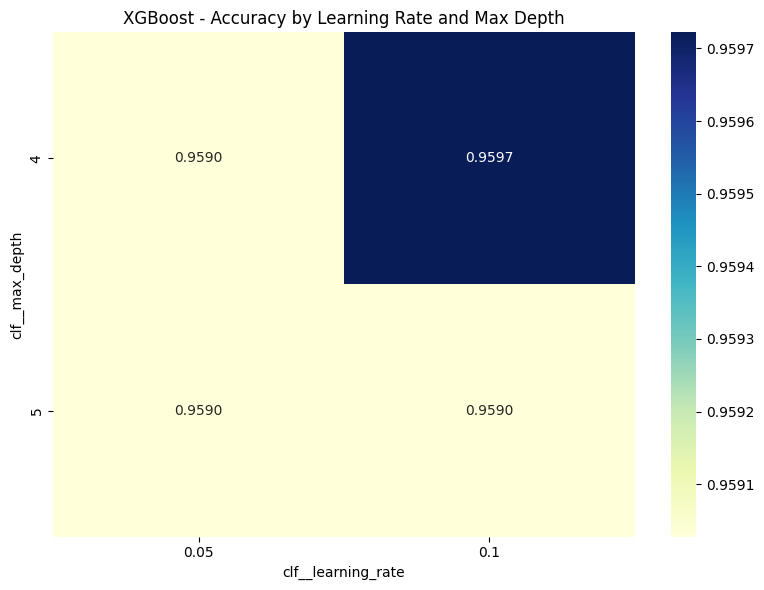

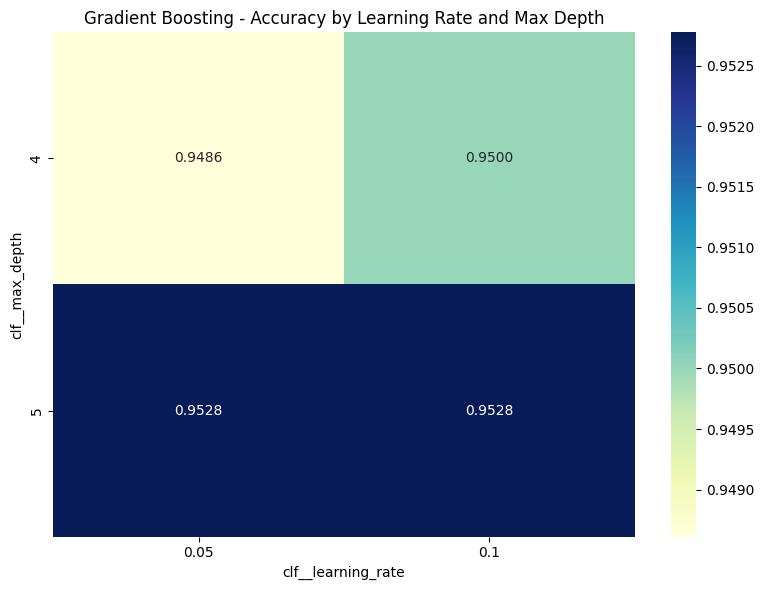

In [ ]:
# 5. Heatmap plotting
def plot_heatmap(grid_search, param_x, param_y, title):
    results_df = pd.DataFrame(grid_search.cv_results_)
    pivot = results_df.pivot_table(values="mean_test_score",
                                   index=f"param_{param_y}",
                                   columns=f"param_{param_x}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel(param_x)
    plt.ylabel(param_y)
    plt.tight_layout()
    plt.show()

plot_heatmap(grid_xgb, 'clf__learning_rate', 'clf__max_depth', "XGBoost - Accuracy by Learning Rate and Max Depth")
plot_heatmap(grid_gb, 'clf__learning_rate', 'clf__max_depth', "Gradient Boosting - Accuracy by Learning Rate and Max Depth")


==== Feature Selection Impact ====

Model: XGBoost
With 5 features -> Accuracy: 0.8444
With 10 features -> Accuracy: 0.9125
With 15 features -> Accuracy: 0.9208
With 20 features -> Accuracy: 0.9514
With 25 features -> Accuracy: 0.9528
With 30 features -> Accuracy: 0.9542
With 35 features -> Accuracy: 0.9472
With 40 features -> Accuracy: 0.9514
With 45 features -> Accuracy: 0.9500
With 50 features -> Accuracy: 0.9514
With 55 features -> Accuracy: 0.9514
With 60 features -> Accuracy: 0.9514

Best k for XGBoost: 30 features -> Accuracy: 0.9542

Top 30 features for XGBoost:
- accX_mean
- accX_std
- accX_max
- accX_min
- accX_energy
- accX_rms
- accX_zcr
- accY_std
- accY_max
- accY_rms
- accY_zcr
- accZ_mean
- accZ_std
- accZ_max
- accZ_min
- accZ_rms
- gyroX_std
- gyroX_min
- gyroX_rms
- gyroZ_std
- gyroZ_max
- gyroZ_min
- gyroZ_energy
- gyroZ_rms
- accMag_mean
- accMag_std
- accMag_energy
- gyroMag_mean
- gyroMag_std
- gyroMag_energy

Model: GradientBoosting
With 5 features -> Accuracy:

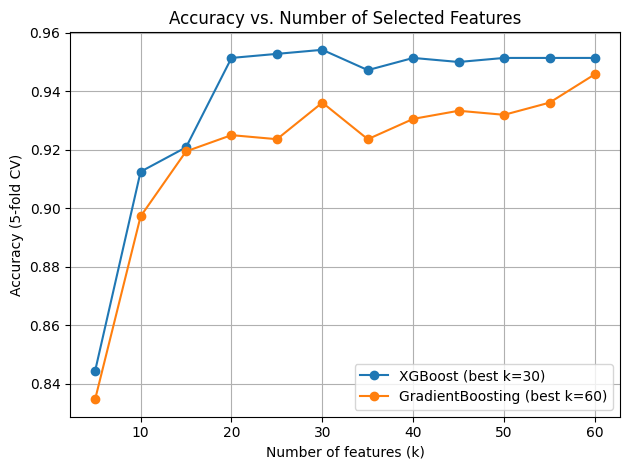

In [ ]:
# 6. Feature selection analysis (auto-select best k)
print("\n==== Feature Selection Impact ====")
models_and_params = {
    "XGBoost": (XGBClassifier(eval_metric='mlogloss', random_state=42), param_grid_xgb),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), param_grid_gb)
}

# Nombres de los features
axes = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']
stats_names = ['mean', 'std', 'max', 'min', 'skew', 'kurt', 'energy', 'rms', 'zcr']
feature_names = [f"{axis}_{stat}" for axis in axes for stat in stats_names]
feature_names += ['accMag_mean', 'accMag_std', 'accMag_energy',
                  'gyroMag_mean', 'gyroMag_std', 'gyroMag_energy']

# Rango de k
feature_counts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

for name, (model, _) in models_and_params.items():
    print(f"\nModel: {name}")
    scores = []
    all_k = []

    for k in feature_counts:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("select", SelectKBest(score_func=f_classif, k=k)),
            ("clf", model)
        ])
        score = cross_val_score(pipe, X, y, cv=5, scoring="accuracy").mean()
        print(f"With {k} features -> Accuracy: {score:.4f}")
        scores.append(score)
        all_k.append(k)

    # Determinar k óptimo
    best_k_index = np.argmax(scores)
    best_k = all_k[best_k_index]
    best_score = scores[best_k_index]
    print(f"\nBest k for {name}: {best_k} features -> Accuracy: {best_score:.4f}")

    # Obtener los features seleccionados con k óptimo
    selector = SelectKBest(score_func=f_classif, k=best_k)
    selector.fit(X, y)
    mask = selector.get_support()
    selected_feats = np.array(feature_names)[mask]

    print(f"\nTop {best_k} features for {name}:")
    for feat in selected_feats:
        print(f"- {feat}")

    # Graficar curva
    plt.plot(all_k, scores, marker='o', label=f"{name} (best k={best_k})")

plt.title("Accuracy vs. Number of Selected Features")
plt.xlabel("Number of features (k)")
plt.ylabel("Accuracy (5-fold CV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 7. Nested cross-validation
print("\n==== Nested Cross-Validation ====")
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, (model, param_grid) in models_and_params.items():
    print(f"\nModel: {name}")
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_classif, k=20)),
        ("clf", model)
    ])
    nested_cv = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    scores = cross_val_score(nested_cv, X, y, cv=outer_cv, scoring='accuracy')
    print(f"Nested CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")
plt.show()


==== Nested Cross-Validation ====

Model: XGBoost
Nested CV Accuracy: 0.9722 ± 0.0176

Model: GradientBoosting
Nested CV Accuracy: 0.9722 ± 0.0132


In [ ]:
from joblib import dump
best_model = grid_xgb.best_estimator_
best_model.fit(X, y) 
dump(best_model, "final_xgb_model.joblib")

import time
sample = X[0].reshape(1, -1)
start = time.time()
pred = best_model.predict(sample)
print("Tiempo de inferencia (1 muestra):", time.time() - start)

Tiempo de inferencia (1 muestra): 0.0005178451538085938


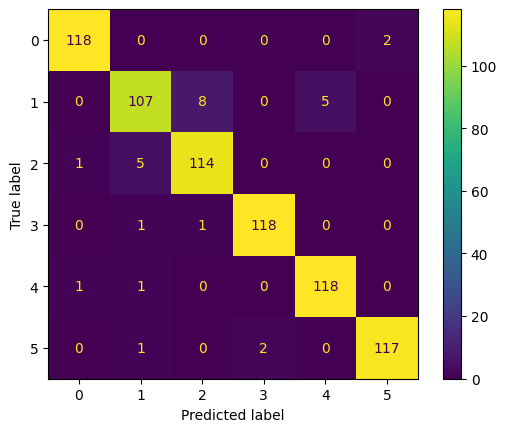

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(best_model, X, y, cv=5)
cm = confusion_matrix(y, y_pred_cv)
ConfusionMatrixDisplay(cm).plot()
plt.show()